1. Import Dependencies and Data

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [3]:
# Load speech data 
# Temporal context
speech_data = np.load('/content/drive/MyDrive/Major_project/dataset/mfccs_file_v1.npy')
speech_data.shape

(294729, 41, 13)

In [4]:
# Load gesture data
gesture_data = np.load('/content/drive/MyDrive/Major_project/dataset/keypoints_file_v4_2_gan.npy')
gesture_data.shape

(294729, 50, 2)

In [5]:
speech_data = speech_data[:100000]
print(speech_data.shape)
gesture_data = gesture_data[:100000]
print(gesture_data.shape)

(100000, 41, 13)
(100000, 50, 2)


In [6]:
# Absolute mfcc features
speech_data = abs(speech_data)

In [7]:
temporal_size = 41
no_of_keypoints = 50
speech_data = speech_data.reshape(len(speech_data), 13*temporal_size)
gesture_data = gesture_data.reshape(len(gesture_data), 2*no_of_keypoints)
print(speech_data.shape)
print(gesture_data.shape)

(100000, 533)
(100000, 100)


In [8]:
# Function to plot keypoint
def plot_keypoints(keypoint):
    pair = [(0,1),(0,4),(0,7),(1,2),(2,3),(4,5),(5,6),(8,9),(8,13),(8,17),(8,21),(8,25),(9,10),(10,11),(11,12),(13,14),(14,15),(15,16),(17,18)
        ,(18,19),(19,20),(21,22),(22,23),(23,24),(25,26),(26,27),(27,28),(8+21,9+21),(8+21,13+21),(8+21,17+21),(8+21,21+21),(8+21,25+21),(9+21,10+21),(10+21,11+21),(11+21,12+21),(13+21,14+21),(14+21,15+21),(15+21,16+21),(17+21,18+21)
        ,(18+21,19+21),(19+21,20+21),(21+21,22+21),(22+21,23+21),(23+21,24+21),(25+21,26+21),(26+21,27+21),(27+21,28+21)]

    width = 640
    height = 480
    frame = np.empty((height,width))
    frame[:,:] = 255
    keypoint = keypoint.reshape(50,2)
    points = []
    for j in range(50):
        x = int(keypoint[j][0]*width)
        y = int(keypoint[j][1]*height)
        points.append((x,y))
    for k in range(50):
        frame = cv.ellipse(frame, points[k] ,(3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    for l in range(len(pair)):
        frame = cv.line(frame, points[pair[l][0]], points[pair[l][1]], (0, 255, 0), 3)
    plt.imshow(frame)

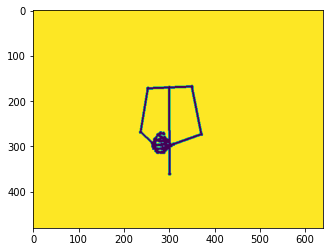

In [9]:
plot_keypoints(gesture_data[97])

In [10]:
# Create tensor data pipeline
data = tf.data.Dataset.from_tensor_slices((speech_data,gesture_data))

In [11]:
data = data.cache()
data = data.shuffle(buffer_size=10000)
data = data.batch(64)
data = data.prefetch(32)

In [12]:
speech, gesture = data.as_numpy_iterator().next()

In [13]:
print(speech.shape)
print(gesture.shape)

(64, 533)
(64, 100)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout

In [15]:
def build_generator():
  model = Sequential()
  model.add(Dense(256,input_shape=(temporal_size*13,), use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Dense(512, use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Dense(1024, use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Dense(no_of_keypoints*2, activation='tanh', use_bias=False))
  
  return model

In [16]:
def build_discriminator():
  model = Sequential()

  model.add(Dense(1024, input_shape=(no_of_keypoints*2,)))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Dense(1))
  
  return model

In [17]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               136448    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131072    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0

In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              103424    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [20]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy(from_logits=True)
d_loss = BinaryCrossentropy(from_logits=True)

In [22]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [24]:
class GestureGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        speech, real_keypoint = batch
        fake_keypoint = self.generator(speech, training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_keypoint, training=True) 
            yhat_fake = self.discriminator(fake_keypoint, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_keypoints = self.generator(speech, training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_keypoints, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [25]:
# Create instance of subclassed model
gesturegan = GestureGAN(generator, discriminator)

In [26]:
# Compile the model
gesturegan.compile(g_opt, d_opt, g_loss, d_loss)

Build Callback



Train

In [27]:
# Training for 
hist = gesturegan.fit(data, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 27s 10ms/step - d_loss: 0.6792 - g_loss: 0.5906
Epoch 2/5
1563/1563 [==============================] - 17s 11ms/step - d_loss: 0.6918 - g_loss: 0.6059
Epoch 3/5
1563/1563 [==============================] - 19s 12ms/step - d_loss: 0.6933 - g_loss: 0.6063
Epoch 4/5
1563/1563 [==============================] - 16s 10ms/step - d_loss: 0.6926 - g_loss: 0.6119
Epoch 5/5
1563/1563 [==============================] - 15s 10ms/step - d_loss: 0.6933 - g_loss: 0.6237


In [49]:
# Training for 
hist = gesturegan.fit(data, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 17s 11ms/step - d_loss: 0.6901 - g_loss: 0.6680
Epoch 2/100
1563/1563 [==============================] - 17s 11ms/step - d_loss: 0.6907 - g_loss: 0.6751
Epoch 3/100
1563/1563 [==============================] - 18s 12ms/step - d_loss: 0.6922 - g_loss: 0.6800
Epoch 4/100
1563/1563 [==============================] - 17s 11ms/step - d_loss: 0.6914 - g_loss: 0.6756
Epoch 5/100
1563/1563 [==============================] - 16s 10ms/step - d_loss: 0.6917 - g_loss: 0.6768
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - d_loss: 0.6888 - g_loss: 0.6845
Epoch 7/100
1563/1563 [==============================] - 17s 11ms/step - d_loss: 0.6913 - g_loss: 0.6774
Epoch 8/100
1563/1563 [==============================] - 16s 10ms/step - d_loss: 0.6889 - g_loss: 0.6829
Epoch 9/100
1563/1563 [==============================] - 16s 10ms/step - d_loss: 0.6889 - g_loss: 0.6878
Epoch 10/100
1563/1563 [==============================]

Review Performance

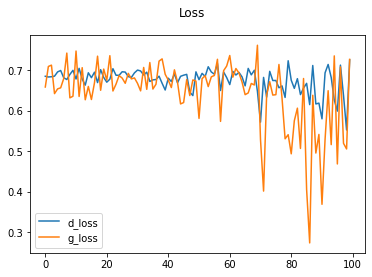

In [50]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [58]:
generator.save('/content/drive/MyDrive/Major_project/generator.h5')
discriminator.save('/content/drive/MyDrive/Major_project/discriminator.h5')

In [51]:
speech_test = speech_data[27]

In [52]:
speech_test = speech_test.reshape(1,533)

In [53]:
keypoint_predicted = generator.predict(speech_test)
keypoint_predicted = keypoint_predicted.reshape(50,2)

1/1 [==============================] - 0s 25ms/step


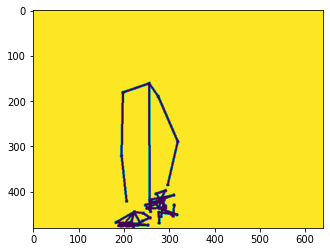

In [54]:
plot_keypoints(keypoint_predicted)

In [55]:
mfcc = np.load("/content/drive/MyDrive/Major_project/dataset/predict_mfcc.npy")
mfcc = abs(mfcc.reshape(465,533))
generated_gesture = generator.predict(mfcc)
print(generated_gesture.shape)

15/15 [==============================] - 0s 3ms/step
(465, 100)


In [56]:
### converting keypoints to images ###
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

# path to store temporary frames
frame_path = '/content/drive/MyDrive/Major_project/generated_images' 

predicted = generated_gesture

# path to plain white image 
plain_image = '/content/drive/MyDrive/Major_project'

# connect keypoints to create gestures
pair = [(0,1),(0,4),(0,7),(1,2),(2,3),(4,5),(5,6),(8,9),(8,13),(8,17),(8,21),(8,25),(9,10),(10,11),(11,12),(13,14),(14,15),(15,16),(17,18),
        (18,19),(19,20),(21,22),(22,23),(23,24),(25,26),(26,27),(27,28),(8+21,9+21),(8+21,13+21),(8+21,17+21),(8+21,21+21),(8+21,25+21),
        (9+21,10+21),(10+21,11+21),(11+21,12+21),(13+21,14+21),(14+21,15+21),(15+21,16+21),(17+21,18+21),(18+21,19+21),(19+21,20+21),
        (21+21,22+21),(22+21,23+21),(23+21,24+21),(25+21,26+21),(26+21,27+21),(27+21,28+21)]

for i in range(len(predicted)):
  #file name to store frames
  filename = 'frame_' + str(i) +'.png' 

  frame = cv.imread(os.path.join(plain_image, 'white_image_hd.png'))
  # reshape predicted keypoints from (1,100) to (50,2)
  keypoint = predicted[i].reshape(50,2)
  # calculate points to draw keypoints in plain white image 
  points = []
  for j in range(50):
    x = int(keypoint[j][0]*1280)
    y = int(keypoint[j][1]*720)

    points.append((x,y))
  # draw circle around keypoints
  for k in range(50):
    frame = cv.ellipse(frame, points[k] ,(3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
  # draw line to join keypoints
  for l in range(len(pair)):
    frame = cv.line(frame, points[pair[l][0]], points[pair[l][1]], (0, 255, 0), 3)
  # file path to store frame
  file_path = os.path.join(frame_path,filename)
  # store frame in specified location
  cv.imwrite(file_path,frame)



1/1 [==============================] - 0s 32ms/step


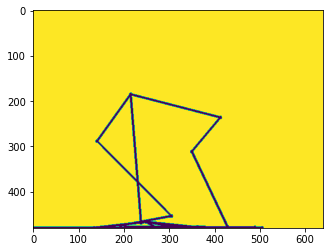

In [44]:
speech_test = mfcc[0].reshape(1,533)
keypoint_predicted = generator.predict(speech_test)
keypoint_predicted = keypoint_predicted.reshape(50,2)
plot_keypoints(keypoint_predicted)

In [57]:
#converting images to video
import cv2
import numpy as np
import glob

frameSize = (1280, 720)

out = cv2.VideoWriter('/content/drive/MyDrive/Major_project/Gan_100.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)

for filename in glob.glob('/content/drive/MyDrive/Major_project/generated_images/*.png'):
    img = cv2.imread(filename)
    out.write(img)

out.release()